#### RNN with LSTMs Language Model using Skip-Gram Dense Embeddings

In [1]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Masking
from keras.layers import LSTM
from keras.layers import Bidirectional


import utils

In [2]:
# constants 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
PADDING = '<pad>'

EMBEDDINGS_SIZE = 50
BATCH_SIZE = 128

GENRE = "Power-Pop" # change to build models for different genres 
MODEL_SAVE_PATH = "power_pop_lstm" # will be used to save and load models
SONG_LIMIT = None # max number of songs to select from a specific genre 

In [3]:
# read in cleaned data
song_df = pd.read_csv('clean_data.csv')
print(song_df.shape)
song_df.head(5)

(163020, 5)


,artist,song_name,lyrics,language,genres
0,ivete sangalo,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,"['Pop', ' Axé', ' Romântico']"
1,ivete sangalo,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,"['Pop', ' Axé', ' Romântico']"
2,ivete sangalo,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,"['Pop', ' Axé', ' Romântico']"
3,ivete sangalo,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,"['Pop', ' Axé', ' Romântico']"
4,ivete sangalo,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,"['Pop', ' Axé', ' Romântico']"


#### Data Preparation: Tokenize Lyrics, Pad Sequences, Create Dense Word Embeddings

In [4]:
# get lyrics in genre
lyrics = utils.get_lyrics_in_genre(song_df, GENRE, verbose=True, song_limit=SONG_LIMIT)
print('\nlyric examples:', '\n', lyrics[0], '\n', lyrics[1], '\n')

# add a single sentence start and end token around each sequence 
tokens = [utils.tokenize_line(line, ngram=1) for line in lyrics] 
sequences = [' '.join(seq) for seq in tokens]
print('token examples:', '\n', sequences[0], '\n', sequences[1])

Selected 775 / 775 in the genre Power-Pop
Total sequences: 24710

lyric examples: 
 la la la la la 
 la la na na na 

token examples: 
 <s> la la la la la </s> 
 <s> la la na na na </s>


Mean Length: 9.09307972480777
Median Length: 9.0
90th Percentile Length: 13.0
Max Length: 68


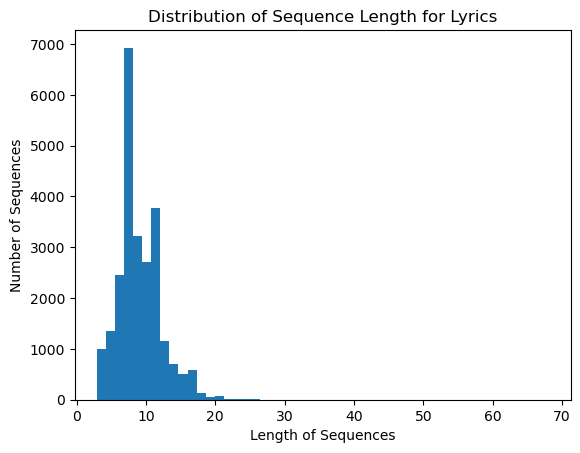

In [5]:
# plot lengths of sequences to determine an appropriate length to pad/truncate to
sequence_lengths = [len(seq) for seq in tokens]

print("Mean Length:", np.mean(sequence_lengths))
print("Median Length:", np.median(sequence_lengths))
print("90th Percentile Length:", np.percentile(sequence_lengths, 90))
print("Max Length:", np.max(sequence_lengths))

plt.hist(sequence_lengths, bins=50)
plt.xlabel("Length of Sequences")
plt.ylabel("Number of Sequences")
plt.title("Distribution of Sequence Length for Lyrics")
plt.show()

In [6]:
# Based on this data, pick a set sequence length that can capture most of the data without excessive padding
SEQUENCE_LENGTH = int(np.percentile(sequence_lengths, 90))
print("SEQUENCE LENGTH =", SEQUENCE_LENGTH, "\n")


def adjust_sequence_length(tokenized_seqs: list, sequence_length: int = SEQUENCE_LENGTH, padding_token: str = PADDING) -> list:
    """
    Pads or truncates all sequences in the provided list to the same length. 
    Adds or removes tokens from the right side of the sequence.

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements
        sequence_length (int): The desired length for all of the sequences
        padding_token (str): The token that should be used to pad short sequences to the proper length

    Returns:
        size_adjusted_sequences (list): A list of lists of tokens, where each inner list is the same length
    """
    size_adjusted_sequences = []
    for sequence in tokenized_seqs:
        if len(sequence) < sequence_length:
            # too short, add padding
            num_padding = sequence_length - len(sequence)
            size_adjusted_sequences.append(sequence + ([padding_token] * num_padding))
        else:
            # truncate sequences longer than the chosen length  
            size_adjusted_sequences.append(sequence[:sequence_length])

    return size_adjusted_sequences


size_adjusted_sequences = adjust_sequence_length(tokens)
print("Number of sequences:", len(size_adjusted_sequences))
print("Length of Sequences:", len(size_adjusted_sequences[0]))
print('Length-adjusted token examples:', '\n', size_adjusted_sequences[0], '\n', size_adjusted_sequences[1])

SEQUENCE LENGTH = 13 

Number of sequences: 24710
Length of Sequences: 13
Length-adjusted token examples: 
 ['<s>', 'la', 'la', 'la', 'la', 'la', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
 ['<s>', 'la', 'la', 'na', 'na', 'na', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [7]:
# Use Tokenizer to map each token to a unique index 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(size_adjusted_sequences)
encoded_sequences = tokenizer.texts_to_sequences(size_adjusted_sequences)

print(tokenizer.word_index)
print()
print("Vocab Size:", len(tokenizer.word_index))
print('encoded examples:', '\n', encoded_sequences[0], '\n', encoded_sequences[1])

{'<pad>': 1, '<s>': 2, '</s>': 3, 'i': 4, 'you': 5, ',': 6, 'the': 7, 'to': 8, 'it': 9, 'and': 10, 'a': 11, "n't": 12, "'s": 13, '.': 14, 'me': 15, 'do': 16, 'in': 17, 'my': 18, 'of': 19, 'on': 20, 'your': 21, 'that': 22, 'all': 23, 'know': 24, 'is': 25, 'we': 26, "'m": 27, 'be': 28, 'for': 29, "'re": 30, 'but': 31, '(': 32, 'so': 33, 'what': 34, 'just': 35, '?': 36, 'she': 37, 'got': 38, ')': 39, 'na': 40, 'up': 41, 'now': 42, "'ll": 43, 'no': 44, 'like': 45, 'can': 46, 'love': 47, 'oh': 48, "'": 49, 'when': 50, 'get': 51, 'with': 52, 'ca': 53, "'ve": 54, 'if': 55, 'see': 56, 'go': 57, 'one': 58, 'out': 59, 'time': 60, 'yeah': 61, 'they': 62, 'never': 63, 'there': 64, 'want': 65, 'not': 66, 'down': 67, 'are': 68, 'have': 69, 'this': 70, 'was': 71, 'will': 72, 'come': 73, 'night': 74, 'at': 75, 'say': 76, 'take': 77, 'baby': 78, 'he': 79, 'make': 80, 'gon': 81, 'world': 82, 'right': 83, 'wan': 84, 'her': 85, 'need': 86, 'away': 87, 'too': 88, 'way': 89, 'let': 90, 'could': 91, 'been': 

In [8]:
# create word embeddings using skip gram algorithm
word_embeddings = Word2Vec(sentences=size_adjusted_sequences, vector_size=EMBEDDINGS_SIZE, window=5, sg=1, min_count=1)
print('Vocab size for word embeddings:', len(word_embeddings.wv))

Vocab size for word embeddings: 7099


In [19]:
# Function that gives mappings from words to their embeddings and  
# indexes from the tokenizers to their embeddings

def map_embeddings(embeddings: Word2Vec, tokenizer: Tokenizer) -> (dict, dict):
    ''' Creates mappings between different token representations 
    Arguments:
        embeddings: Word2Vec word embeddings for the data (maps tokens to embedding vectors)
        tokenizer: Tokenizer used to tokenize the data (maps token to index)
    Returns:
        (dict): mapping from word to its embedding vector
        (dict): mapping from index to its embedding vector
    '''
    # initialize dictionaries 
    token_to_embedding = {}
    index_to_embedding = {}

    # tokenizer maps tokens to unique indices 
    for token, index in tokenizer.word_index.items():
        embedding = embeddings[token]

        token_to_embedding[token] = embedding
        index_to_embedding[index] = embedding

    return (token_to_embedding, index_to_embedding)


token_to_embedding, index_to_embedding = map_embeddings(word_embeddings.wv, tokenizer)

# Set embedding associated with padding token to all zeros -- will be used to mask this token
padding_index = tokenizer.word_index.get(PADDING)
index_to_embedding[padding_index] = [0] * EMBEDDINGS_SIZE
token_to_embedding[PADDING] = [0] * EMBEDDINGS_SIZE

# Fill in unused index zero to avoid dimension mismatch
index_to_embedding[0] = [0] * EMBEDDINGS_SIZE

#### Generate Samples for Training

In [20]:
def data_generator(data: list, num_sequences_per_batch: int, index_2_embedding: dict) -> (np.array, np.array):
    '''
    Returns a data generator to train the neural network in batches

    X data will be represented in embedding form.
    Y data will be represented with one hot vectors. 

    Args:
    data (list of lists): tokenized sequences represented by their unique index encodings 
    num_sequences_per_batch (int): batch size yielded on each iteration of the generator 
    index_2_embedding (dict): mapping between unique token indices and dense word embeddings 

    Returns:
    X_batch_embeddings (3-D numpy array): sequences of embeddings with dimensions (batch size, num timesteps, embedding size)
                                          Take the first (SEQUENCE_LENGTH - 1) tokens of each sequence
    y_batch (3-D numpy array): sequences of one hot vectors with dimensions (batch size, num timesteps, vocab size)
                                          Take the last (SEQUENCE_LENGTH - 1) tokens of each sequence 
                                          (X shifted forward one token so that the neural net predicts the next word in the sequence for each timestep)
    '''
    # iterate over data in batches - stored in the form of unique token indices 
    i = 0
    while True:
        # get samples that we'd like to train on for this batch 
        data_batch = data[i:i+num_sequences_per_batch]

        # increment i with each batch 
        i += num_sequences_per_batch

        # split into X and Y -- shifted sequence so that for each timestep, Y is the token that follows X 
        X = [sequence[:-1] for sequence in data_batch]
        Y = [sequence[1:] for sequence in data_batch]

        # get embeddings for X data 
        X_embeddings = []
        for X_sequence in X:
            X_sequence_embeddings = [index_2_embedding[token_idx] for token_idx in X_sequence]
            X_embeddings.append(X_sequence_embeddings)

        # get one hot vectors for Y data 
        Y_one_hot_vectors = []
        for Y_sequence in Y:
            Y_one_hot = to_categorical(Y_sequence, num_classes=len(index_2_embedding))
            Y_one_hot_vectors.append(Y_one_hot)

        # yield statement instead of return for generator 
        yield(np.array(X_embeddings), np.array(Y_one_hot_vectors))


# demo the data generator

demo_data_generator = data_generator(encoded_sequences, BATCH_SIZE, index_to_embedding)
demo_sample = next(demo_data_generator)
print("X batch shape:", demo_sample[0].shape)
print("y batch shape:", demo_sample[1].shape)

X batch shape: (128, 12, 50)
y batch shape: (128, 12, 7100)


#### Create and Train Model

In [65]:
def lstm_rnn(data: np.array, 
             index_2_embedding: dict, 
             num_epochs: int=1, 
             num_sequences_per_batch: int=BATCH_SIZE, 
             sequence_length: int=SEQUENCE_LENGTH):
    """
    Creates and trains an RNN with LSTM cells using given training data and batch size.

    Args:
        data (list of lists): encoded sequences of training data represented by token indices 
        index_2_embedding (dict): mapping from token index -> word2vec embeddings 
        num_epochs (int): number of training epochs
        num_sequences_per_batch (int): batch size for training data 
        sequence_length (int): number of tokens in each training sample 
    Returns:
        A trained Neural Network language model
    """
    # define model parameters
    hidden_units = 128
    hidden_input_dim = (sequence_length - 1, EMBEDDINGS_SIZE)      # (number of steps, number of features per step)
    output_dim = len(index_2_embedding)                            # vocab size 

    # instantiate model
    model = Sequential()

    # mask the padding token 
    model.add(Masking(mask_value=0.0))

    # hidden layer
    model.add(Bidirectional(LSTM(hidden_units, 
                                 input_shape=hidden_input_dim,
                                 return_sequences=True)))

    # dropout layer to prevent overfitting 
    model.add(Dropout(0.5))

    # output layer
    model.add(Dense(units=output_dim, activation='softmax'))

    # configure the learning process
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # total number of batches per epoch 
    steps_per_epoch = len(data)//num_sequences_per_batch

    for _ in range(num_epochs):
        # create a new data generator for us to iterate through
        train_generator = data_generator(data, num_sequences_per_batch, index_2_embedding)
        # train model 
        model.fit(x=train_generator, steps_per_epoch=steps_per_epoch)

    model.summary()
    return model

In [66]:
model = lstm_rnn(np.array(encoded_sequences), index_to_embedding, num_epochs=10)

# save trained model 
# model.save(MODEL_SAVE_PATH)

193/193 [==============================] - 40s 208ms/step - loss: 0.9639 - accuracy: 0.8449
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_6 (Masking)         (None, None, None)        0         
                                                                 
 bidirectional_6 (Bidirecti  (None, None, 256)         183296    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_6 (Dense)             (None, None, 7100)        1824700   
                                                                 
Total params: 2007996 (7.66 MB)
Trainable params: 2007996 (7.66 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________

#### Create functions to generate new sequences 

In [67]:
def generate_sequences(model: Sequential, 
                      tokenizer: Tokenizer, 
                      index_2_embedding: dict, 
                      num_seq: int):
    '''
    Generates a given number of sequences using the given RNN language model.
    Will begin the sequence generation with n-2 PADDING tokens and a SENTENCE_BEGIN token.
    Returned sequences will have the BEGIN, END, and PADDING tokens removed

    Args:
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        num_seq: the number of sequences to generate 

    Returns: 
        A list of strings, where each string is a generated sequence with special tokens removed 
    '''
    seed =  ([PADDING] * (SEQUENCE_LENGTH - 1)) + [SENTENCE_BEGIN]
    
    sequences = []
    for _ in range(num_seq):
        seq = generate_seq(model, tokenizer, index_2_embedding, seed)
        seq = ' '.join(seq)

        # remove special tokens
        seq = seq.replace(SENTENCE_BEGIN, '')
        seq = seq.replace(SENTENCE_END, '')
        seq = seq.replace(PADDING, '')

        sequences.append(seq.strip())
        
    return sequences



def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 index_2_embedding: dict, 
                 seed: list):
    '''
    Generates a single sequence using the given model starting with a SENTENCE_BEGIN and ending with a SENTENCE_END token. 
    Since an RNN takes input sequences of fixed length, use a sliding window to continually predict the next word. 

    Args:
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        seed: the initial tokens to feed the RNN
    Returns: 
        An array of tokens representing a sequence 
    '''
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)
    sentence_end_index = tokenizer.word_index.get(SENTENCE_END)

    # track the unique token indices for the sequence 
    sequence_indices = [tokenizer.word_index.get(tok) for tok in seed] 

    input_length = SEQUENCE_LENGTH - 1

    # until we get a SENTENCE_END token
    while sequence_indices[-1] != sentence_end_index:
        # get latest tokens to use as inputs 
        input_sequence = sequence_indices[-1*input_length:]

        # convert the input sequence to embeddings
        input_embeddings = np.array([[index_2_embedding[idx] for idx in input_sequence]])

        # get probability distribution on vocabulary for the next token in the sequence 
        predictions = model.predict(input_embeddings, verbose=False)[0] # [0] to get first in batch of size 1 

        prediction = predictions[-1]    # [-1] to get last probability distribution output

        next_tok_idx = np.random.choice(len(prediction), p=prediction)

        # skip mid-sentence SENTENCE_BEGIN and PADDING tokens
        if next_tok_idx == sentence_begin_index or next_tok_idx == padding_index:
            continue

        # add newly generated token to our sequence 
        sequence_indices.append(next_tok_idx)

    # convert to words 
    tokenizer_words = list(tokenizer.word_index.keys())
    tokenizer_indices = list(tokenizer.word_index.values())
    sequence = [tokenizer_words[tokenizer_indices.index(idx)] for idx in sequence_indices]
    return sequence

In [70]:
# load in model 
# model = keras.saving.load_model(MODEL_SAVE_PATH)

# Generate new lyrics 
generated_sequences = generate_sequences(model, tokenizer, index_to_embedding, num_seq=10)
print("Sequence generated with LSTM model:\n")
for seq in generated_sequences:
    print(seq)

Sequence generated with LSTM model:

ha sun-glasses chrome nice record everyone
i'me u.s.a sights
snatched discotheque aim carver u.s.a act ...
we both shared really 'paint pins falls brown bell lasts
seems smart janie business . each styles hollaback ,
reward scotch prayer thieves bah followed suggestion reason gossip lieing
theres christian south wyman spinning stash birdie vice pick ship ay
forty borealis ear fairytale genius grace copy nickel worries beverly worthwhile trials dragon slave z fast
crack fortunate maureen thrill-seek plasma promise looking
swear fear crawls aside cigarettes reassure stay one believe
